In [2]:
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt
from feature_selection_tf2 import FeatureSelection
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

2023-07-24 15:28:32.844888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def relax(x):
    noise = np.random.rand(x.shape[0])
    tmp = 10*(np.log(x)-np.log(1-x)+np.log(noise)-np.log(1-noise))
    return 1/(1+np.exp(-tmp))

def relax_2(x, noise):
    tmp = 10*(np.log(x)-np.log(1-x)+np.log(noise)-np.log(1-noise))
    return 1/(1+np.exp(-tmp))

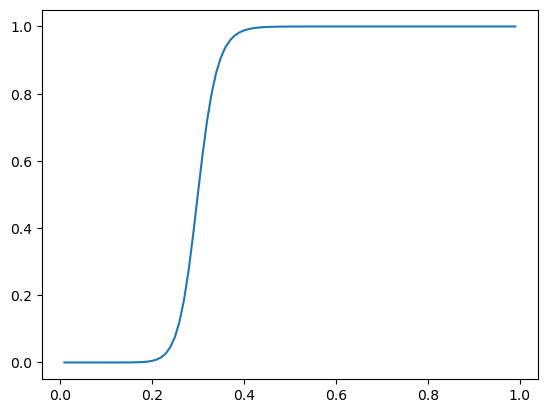

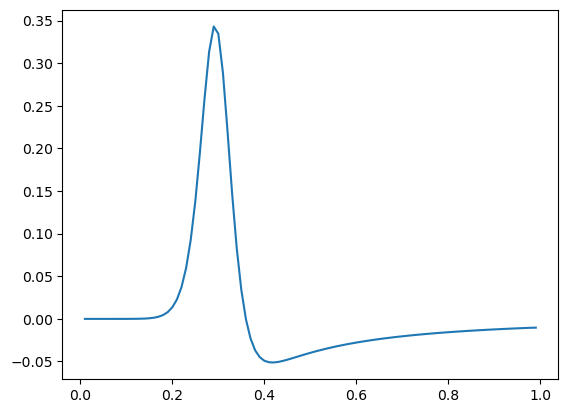

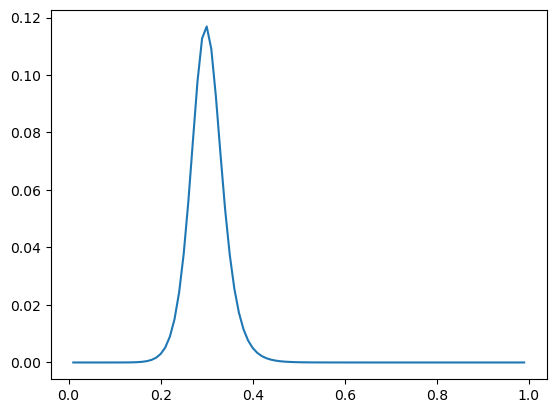

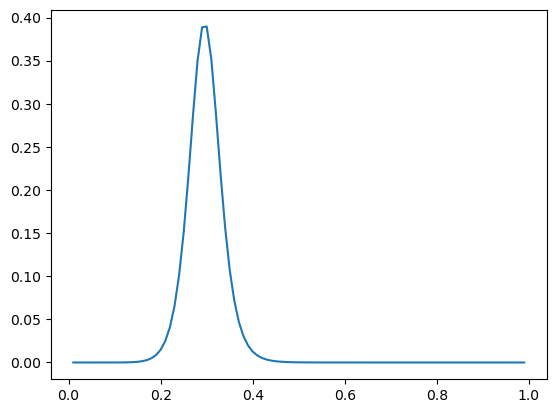

In [3]:
x = np.arange(0, 1, 0.01)[1:]
y = relax_2(x, 0.7)
plt.plot(x, y)
plt.show()
x = np.arange(0, 1, 0.01)[1:]
y = relax_2(x, 0.7)
#print(np.gradient(y/x))
plt.plot(x, np.gradient(y/x))
plt.show()
#print(np.gradient(y))
plt.plot(x, np.gradient(y))
plt.show()
plt.plot(x, np.gradient(y)/x)
plt.show()

In [21]:
def gen_dataset(samples, rate):
    N = samples
    pos_rate = rate
    mean_abs = np.arange(1, 0, -0.1)
    var = 2
    
    def gen_ins(label):
        mean = mean_abs if label else -mean_abs
        ins = []
        for i in mean:
            ins.append(np.random.normal(i, 2))
        return np.array([np.random.normal(0, 1)]+ins+[np.random.normal(0, 2)]+[np.random.normal(0, 2)]+[0.]+[0.])
    
    labels = np.reshape(np.array(np.random.rand(N) < pos_rate, np.int32), [-1, 1])
    return np.array([gen_ins(label) for label in labels]), labels

In [22]:
samples = 100000

x_train, y_train = gen_dataset(samples, 0.2)
x_test, y_test = gen_dataset(int(samples/5), 0.2)

In [23]:
class MyLayer(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


class FS(Model):
  def __init__(self):
    super(FS, self).__init__()
    self.fs = FeatureSelection(1)
    self.d1 = Dense(16, activation='relu')
    #self.d1 = MyLayer(16)
    self.d2 = Dense(8, activation='relu')
    self.d3 = Dense(1, activation='sigmoid')

  def call(self, x, training=True):
    x = self.fs(x, training)
    x = self.d1(x)
    x = self.d2(x)
    self.add_loss(self.fs.losses[0])
    return self.d3(x)

  def loss(self):
    return self.fs.losses

batch_size = 8

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

model = FS()
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(0.01)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_auc = tf.keras.metrics.AUC(num_thresholds=3)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_auc = tf.keras.metrics.AUC(num_thresholds=3)

@tf.function
def train_step(ins, labels):
  with tf.GradientTape() as tape:
    predictions = model(ins, training=True)
    loss = loss_object(labels, predictions) + 0.0001*sum(model.losses)
  gradients = tape.gradient(loss, model.trainable_variables)
  #print(model.trainable_variables)
  #print(gradients)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_auc(labels, predictions)


@tf.function
def test_step(images, labels):
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_auc(labels, predictions)


# step = 0
# for x_ins, y_ins in train_ds:
#   if step < 3:
#     print(step)
#     train_step(x_ins, y_ins)
#   else:
#     break
#   step+=1
# import sys
# sys.exit()

EPOCHS = 5
for epoch in range(EPOCHS):
  train_loss.reset_states()
  test_loss.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'auc: {train_auc.result()}, '
    f'Test Loss: {test_loss.result()}, '
    f'auc: {test_auc.result()}, '
  )
  print(tf.sigmoid(model.trainable_variables[0]))
    
#epochs = 1
#batch_size = 8
#labels = tf.convert_to_tensor(x, tf.float32)
#input_queue = tf.train.slice_input_producer([tf.convert_to_tensor(x, tf.float32)], num_epochs=epochs, shuffle=False)
#ins = tf.train.batch([input_queue], batch_size = batch_size, enqueue_many = True)
#ins = tf.layers.dense(ins, 16, tf.nn.relu)
#ins = tf.layers.dense(ins, 8, tf.nn.relu)
#ad_logits = tf.layers.dense(ins, 1)
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=ad_logits))
#global_step = tf.Variable(0, name='global_step')
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minize(loss, global_step)

Epoch 1, Loss: 0.31392160058021545, auc: 0.7564547657966614, Test Loss: 0.278493195772171, auc: 0.7826977968215942, 
tf.Tensor(
[0.80150497 0.89400643 0.8818237  0.8774233  0.8514245  0.83691865
 0.8292443  0.8248007  0.8151828  0.8079415  0.80715823 0.8007702
 0.8040248  0.7997614  0.7997614 ], shape=(15,), dtype=float32)
Epoch 2, Loss: 0.2953316867351532, auc: 0.7631930708885193, Test Loss: 0.2767474949359894, auc: 0.783268928527832, 
tf.Tensor(
[0.802862   0.93305606 0.92159516 0.90940976 0.8943026  0.87182474
 0.8539931  0.8459486  0.8238095  0.8179232  0.80935574 0.8019294
 0.80514383 0.79952276 0.79952276], shape=(15,), dtype=float32)
Epoch 3, Loss: 0.2899540066719055, auc: 0.7664836049079895, Test Loss: 0.2760123908519745, auc: 0.7842655777931213, 
tf.Tensor(
[0.80203426 0.9489346  0.9389648  0.9297576  0.9144518  0.8912297
 0.87134326 0.85774815 0.83188903 0.8252287  0.8113758  0.8018431
 0.80755603 0.79928374 0.79928374], shape=(15,), dtype=float32)
Epoch 4, Loss: 0.2863603830

In [7]:
# encoding:utf-8
# Authered by: chaofeng.gcf
#=============================================
"""The API detail
NOTE: concrete dropout
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_array_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.keras import activations
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.base_layer import Layer

class MyLayer(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class FeatureSelection(Layer):
  """Feature selection for sparse inputs.
  """

  def __init__(self,
               embedding,
               l1=0.1,
               init_min=0.8,
               init_max=0.8,
               **kwargs):
    super(FeatureSelection, self).__init__(**kwargs)
    self.embedding = int(embedding)
    self.l1 = float(l1)
    self.regularizer = regularizers.L1L2(l1=l1)
    self.init_min = math.log(init_min) - math.log(1-init_min)
    self.init_max = math.log(init_max) - math.log(1-init_max)

  def build(self, input_shape):
    input_shape = tensor_shape.TensorShape(input_shape)
    if tensor_shape.dimension_value(input_shape[-1]) is None:
      raise ValueError('The last dimension of the inputs should be defined. Found `None`.')
    self.dims = int(tensor_shape.dimension_value(input_shape[-1]) / self.embedding)
    self.weight = self.add_weight('weight',
                                  shape=[self.dims],
                                  initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                  regularizer=self.regularizer,
                                  trainable=True)
    #self._retain_prob = math_ops.sigmoid(self.weight)
    #self.scale_prob = array_ops.reshape(gen_array_ops.tile(
    #                                        array_ops.reshape(self._retain_prob, [-1,1]),
    #                                        [1,self.embedding]),
    #                                    [-1])
    self.built = True

  def _dropped_inputs(self, inputs):
    epsion = 10**-7
    scale = 0.1
    self._retain_prob = math_ops.sigmoid(self.weight)
    self._noise = random_ops.random_uniform(array_ops.shape(self.weight), minval=0, maxval=1)
    drop_prob = gen_math_ops.log(self._retain_prob + epsion) \
                - gen_math_ops.log(1 - self._retain_prob + epsion) \
                + gen_math_ops.log(self._noise + epsion) \
                - gen_math_ops.log(1 - self._noise + epsion)
    self._drop_prob = math_ops.sigmoid(drop_prob / scale)
    

    #random_drop = array_ops.reshape(gen_array_ops.tile(
    #                                    array_ops.reshape(self._drop_prob, [-1,1]),
    #                                    [1,self.embedding]),
    #                                [-1])
    #outputs = inputs * random_drop / self.scale_prob
    outputs = inputs * self._drop_prob / self._retain_prob
    #outputs = inputs * self._drop_prob / self.weight
    return outputs

  def _call(self, inputs, training=True):
    return self._dropped_inputs(inputs)

  def call(self, inputs, training=True):
    if training:
      outputs = self._dropped_inputs(inputs)
    else:
      outputs = array_ops.identity(inputs)
    return outputs

  def compute_gradient(self, inputs, grad):
    grads = {}
    with tf.GradientTape() as tape:
      pred = self(inputs)
      # 下面这里的pred是一个标量，可以直接求导
      grads['weight'] = tape.gradient(pred, [self.weight], output_gradients=grad)
    return grads

  @property
  def loss(self):
    return self.regularizer(self._drop_prob) if hasattr(self, '_drop_prob') else []

  @property
  def retain_prob(self):
    return self._retain_prob

  @property
  def drop_prob(self):
    return self._drop_prob if hasattr(self, '_drop_prob') else []

  @property
  def noise(self):
    return self._noise

if __name__ == '__main__':
    fs = FeatureSelection(1)
    dense = MyLayer(5)
    #x = random_ops.random_uniform([32, 2212])
    #x = random_ops.random_uniform([1, 10])
    with tf.GradientTape() as tape:
        x = random_ops.random_uniform([1, 10])
        flag = 1
        if flag:
            tape.watch(x)
            predictions = fs(x, training=True)
            gradients = tape.gradient(predictions, [fs.trainable_variables, x])
            print("variables:", fs.trainable_variables)
            print("g:", gradients)
            print("loss: ", fs.losses)
        else:
            tape.watch(x)
            p2 = dense(x)
            g2 = tape.gradient(tf.multiply(x,tf.constant([4], tf.float32)), [x])
            print(dense.trainable_variables)
            print(g2)

variables: [<tf.Variable 'feature_selection_1/weight:0' shape=(10,) dtype=float32, numpy=
array([1.3862944, 1.3862944, 1.3862944, 1.3862944, 1.3862944, 1.3862944,
       1.3862944, 1.3862944, 1.3862944, 1.3862944], dtype=float32)>]
g: [[<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-8.6300485e-02,  3.8031673e-01, -6.6054217e-03, -8.1653841e-02,
       -7.1447849e-02,  1.0231194e-11, -8.2393549e-02, -2.4951474e-01,
        1.2898615e-01, -2.0859030e-01], dtype=float32)>], <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.2500000e+00, 7.4562520e-02, 1.2499986e+00, 1.2499913e+00,
        1.2500000e+00, 6.2071940e-12, 1.2500000e+00, 1.2500000e+00,
        5.8289338e-02, 1.2500000e+00]], dtype=float32)>]
loss:  [<tf.Tensor: shape=(), dtype=float32, numpy=1.3862944>]


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

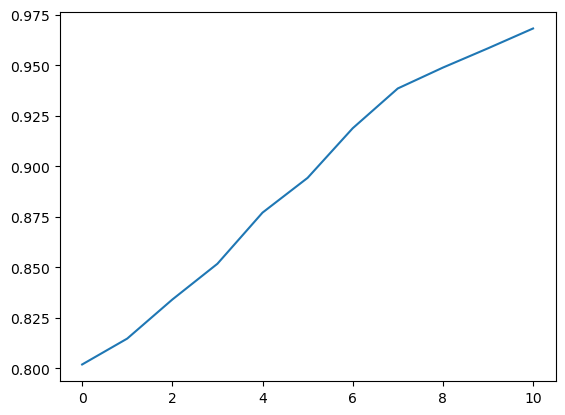

In [8]:
KL=[10, 9, 8, 7, 6, 5 ,4, 3, 2, 1, 0]
imp=[0.96808696, 0.9582648, 0.9487216, 0.9383963, 0.91869634, 0.8941474, 0.8769399, 0.8516339, 0.83393186, 0.81460893, 0.8017878, 0.8091553, 0.7988053, 0.7988053, 0.8015107]
imp=[0.96808696, 0.9582648, 0.9487216, 0.9383963, 0.91869634, 0.8941474, 0.8769399, 0.8516339, 0.83393186, 0.81460893, 0.8017878]
plt.plot(KL, imp)
plt.set_xlabel('KL')
plt.show()

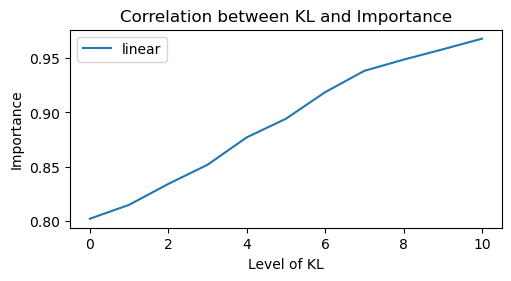

In [11]:
KL=[10, 9, 8, 7, 6, 5 ,4, 3, 2, 1, 0]
imp=[0.96808696, 0.9582648, 0.9487216, 0.9383963, 0.91869634, 0.8941474, 0.8769399, 0.8516339, 0.83393186, 0.81460893, 0.8017878, 0.8091553, 0.7988053, 0.7988053, 0.8015107]
imp=[0.96808696, 0.9582648, 0.9487216, 0.9383963, 0.91869634, 0.8941474, 0.8769399, 0.8516339, 0.83393186, 0.81460893, 0.8017878]
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(KL, imp, label='linear')
ax.set_xlabel('Level of KL')
ax.set_ylabel('Importance')
ax.set_title("Correlation between KL and Importance")
ax.legend()

<BarContainer object of 4 artists>

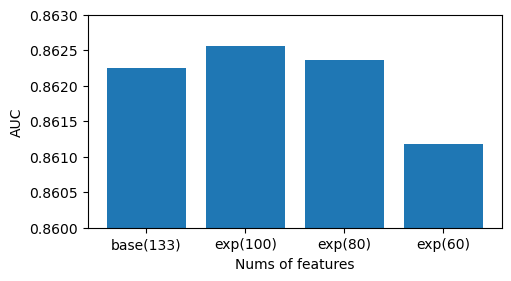

In [19]:
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
categories = ['base(133)', 'exp(100)', 'exp(80)', 'exp(60)']
auc=[0.862249, 0.862565, 0.862369, 0.861177]
ax.set_xlabel('Nums of features')
ax.set_ylabel('AUC')
plt.ylim(0.860, 0.863)
ax.bar(categories, auc)